# Convolutional Neural Networks

This tutorial implements a popular convolutional neural network architecture called VGG-16. It was designed by the Visual Geometry Group at the University of Oxford, and achieved state of the art results on the ImageNet challenge at the time of its release.  
  
As usual, the cell below is for Python 2 compatibility, and can be ignored if you are using Python 3.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [3]:
import sys
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt

## Loading CIFAR-10 Dataset

The CIFAR-10 dataset is a dataset of 32x32 color images collected by researchers at the University of Toronto. As the name suggests, there are 10 classes, which we will figure out by loading some of the data! We have downloaded the data as a "pickled" (byte stream serialization) object into the `data` folder, and we load it below:

In [4]:
def unpickle(file):
    with open(file, 'rb') as f:
        if sys.version[0] == '3':
            data = pickle.load(f, encoding='bytes')
        elif sys.version[0] == '2':
            data = pickle.load(f)
    return data

cifar10 = unpickle('../data/cifar-10-data')

We have now loaded the dataset as a dictionary (a data structure in Python mapping keys to labels) - we observe that we have 10000 images, each of which is specified by 3072 values since 32x32x3=3072.

In [5]:
images = np.array(cifar10[b'data'])
labels = np.array(cifar10[b'labels'])

print(images.shape)
print(labels.shape)

(10000, 3072)
(10000,)


Below, we plot some sample images to figure out the class labels:

In [6]:
def plot_classes(n=7):
    """Plots n images for each class"""
    fig, axes = plt.subplots(nrows=10, ncols=n, figsize=(n, 10))
    for i in range(10):
        for j, k in enumerate(np.where(labels == i)[0][:n]):
            vec = images[k]
            img = vec.reshape(3, 32, 32).transpose([1, 2, 0])
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
    plt.show()

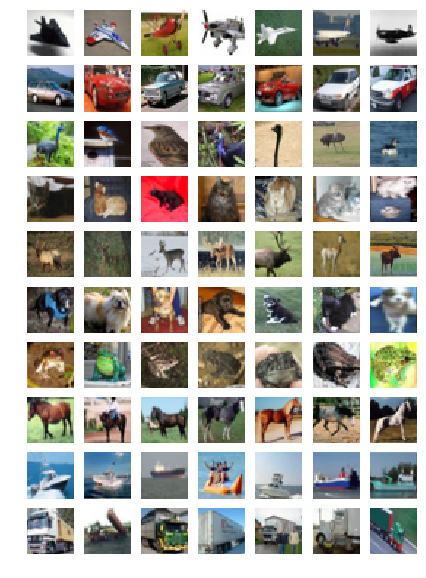

In [7]:
plot_classes()

As you can probably tell, the 10 classes are:   
Airplane, Automobile, Bird, Cat, Deer, Dog, Frog, Horse, Ship, Truck.

Finally, we split the data into training and test folds:

In [8]:
# generates random permutation of numbers from 0-9999
shuffle = np.random.permutation(10000)

# reorder images, labels according to same random permutation
images = images[shuffle, :]
labels = labels[shuffle]

# use first 8000 images as training set
x_train = images[:8000, :]
y_train = labels[:8000]

# use last 2000 images as test set
x_test = images[8000:, :]
y_test = labels[8000:]

## Creating a Convolutional Neural Network

Now we can start to implement a CNN in TensorFlow - as usual, we start with placeholders for our data. Unlike last time, we will not explicitly one-hot encode our data, and let the TensorFlow backend handle it. One-hot encoding produces sparse matrices (matrices whose entries are mostly 0s) that can be manipulated much more efficiently than actually creating a matrix that is mostly full of 0s.  
  
As usual, we start with our placeholders for our training data and labels. Since we are not one-hot encoding the labels, the `y` placeholder is one-dimensional.

In [9]:
x = tf.placeholder(tf.float32, [None, 32, 32, 3], 'images')

# storing decimal places for integers is a waste of space
y = tf.placeholder(tf.int64, [None], 'labels')

Now we create our first two convolutional layers:  
The key function here is `tf.nn.conv2d()`

In [10]:
# remember to group variables and tensors using the variable scope!
with tf.variable_scope('conv1_1'):
    # weights have shape [filter height, filter width, depth_in, depth_out]
    w1 = tf.get_variable('W', shape=[3, 3, 3, 64])
    
    # biases have shape [depth_out]
    b1 = tf.get_variable('b', shape=[64])
    
    # the strides argument controls how the size of the steps of the sliding window
    # 'SAME' padding zero-pads the input tensor so the output tensor has the same size
    conv1 = tf.nn.conv2d(x, w1, strides=[1, 1, 1, 1], padding='SAME')
    
    # apply ReLU activation function
    h1 = tf.nn.relu(conv1 + b1)

with tf.variable_scope('conv1_2'):
    w2 = tf.get_variable('W', shape=[3, 3, 64, 64])
    b2 = tf.get_variable('b', shape=[64])
    conv2 = tf.nn.conv2d(h1, w2, strides=[1, 1, 1, 1], padding='SAME')
    h2 = tf.nn.relu(conv2 + b2)    

Now we create our first pooling layer:  
The key function here is `tf.nn.max_pool()`

In [11]:
# the max_pool() takes the inputs, the pooling window size, strides, and padding
with tf.variable_scope('pool1'):
    p1 = tf.nn.max_pool(h2, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')

At this point, we will basically repeat what we have done so far a number of times - to avoid writing the same code over and over again, we implement helper functions that create convolutional, pooling, and fully connected layers (this is common practice in writing neural nets!). Think about what the arguments to this function should be - i.e. what are the decisions we have to make regarding hyperparameters?

In [12]:
def conv_layer(inputs, k_size, n_filters, scope):
    depth = inputs.get_shape().as_list()[-1]
    with tf.variable_scope(scope):
        w = tf.get_variable('W', [k_size, k_size, depth, n_filters])
        b = tf.get_variable('b', [n_filters])
        conv = tf.nn.conv2d(inputs, w, [1, 1, 1, 1], padding='SAME')
        return tf.nn.relu(conv + b)

    
def pooling_layer(inputs, k_size, scope):
    with tf.variable_scope(scope):
        strides = [1, k_size, k_size, 1]
        return tf.nn.max_pool(inputs, strides, strides, padding='SAME')
    
    
def fc_layer(inputs, n_units, scope):
    length = inputs.get_shape().as_list()[-1]
    with tf.variable_scope(scope):
        w = tf.get_variable('W', [length, n_units])
        b = tf.get_variable('b', [n_units])
        return tf.nn.xw_plus_b(inputs, w, b)

Make sure you take the time to understand the functions above in detail! (Note in particular that the output of the `fc_layer()` function has not been passed through an activation function!)
  
Continuing where we left off, we implement the rest of the 
convolutional layers:

![VGG](../images/vgg16.png)

In [13]:
conv2_1 = conv_layer(p1, 3, 128, 'conv2_1')
conv2_2 = conv_layer(conv2_1, 3, 128, 'conv2_2')
pool2 = pooling_layer(conv2_2, 2, 'pool2')

conv3_1 = conv_layer(pool2, 3, 256, 'conv3_1')
conv3_2 = conv_layer(conv3_1, 3, 256, 'conv3_2')
conv3_3 = conv_layer(conv3_2, 3, 256, 'conv3_3')
pool3 = pooling_layer(conv3_3, 2, 'pool3')

conv4_1 = conv_layer(pool3, 3, 512, 'conv4_1')
conv4_2 = conv_layer(conv4_1, 3, 512, 'conv4_2')
conv4_3 = conv_layer(conv4_2, 3, 512, 'conv4_3')
pool4 = pooling_layer(conv4_3, 2, 'pool4')

conv5_1 = conv_layer(pool4, 3, 512, 'conv5_1')
conv5_2 = conv_layer(conv5_1, 3, 512, 'conv5_2')
conv5_3 = conv_layer(conv5_2, 3, 512, 'conv5_3')
pool5 = pooling_layer(conv5_3, 2, 'pool5')

At the end of VGG-16, there is a fully connected layer and a softmax layer: we implement both using the `fc_layer()` helper method.
  
Also of note is that fully connected layers take in matrices of size `[batch_size, length]` as input, whereas convolutional layers take in inputs of `[batch_size, height, width, channels]`. So before our fully connected layers, we flatten the tensor to be 2-dimensional.

In [14]:
# when reshaping, -1 means that Python should infer the size automatically
flat = tf.reshape(pool5, [-1, 512])
fc6 = tf.nn.relu(fc_layer(flat, 4096, 'fc6'))

scores = fc_layer(fc6, 10, 'softmax')
preds = tf.nn.softmax(scores)

Below are some tensors we will use to compute accuracy:

In [15]:
correct = tf.equal(tf.argmax(preds, axis=1), y)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

The `tf.nn.sparse_softmax_cross_entropy_with_logits()` function automatically handles the one-hot encoding (to speed up calculations with sparse matrices) and softmax calculations (for numerical stability with exponentials).

In [16]:
with tf.variable_scope('optimization'):
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=scores))
    train_step = tf.train.AdamOptimizer(0.001).minimize(loss)

## Training the Network

**NOTE:** This will take a while... (several hours)

In [17]:
n_epochs = 1000
batch_size = 256

In [18]:
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(init)

In [ ]:
for n in range(n_epochs):
    shuffle = np.random.permutation(x_train.shape[0])
    for i in range(0, x_train.shape[0], batch_size):
        idx = shuffle[i: i + batch_size]
        x_batch = x_train[idx].reshape(-1, 3, 32, 32).transpose([2, 3, 1])
        y_batch = y_train[idx]
        sess.run(train_step, feed_dict={x: x_batch, y: y_batch})
    l, a = sess.run([lossm accuracy], feed_dict={x: x_train, y: y_train})
    print('epoch {:2d} loss={:.3f} accuracy={:.2f}%'.format(n, l, 100*a))

## Load Pre-trained Model

In [ ]:
# TODO: Train model 

In [ ]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
saver = tf.train.import_meta_graph('../models/cnn/vgg.meta')
saver-restore(sess, tf.train.latest_checkpoint('../models/cnn'))
x = tf.get_default_graph().get_tensor_by_name('')
preds  = tf.get_default_graph().get_tensor_by_name('')

In [ ]:
classes = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 
           'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

In [ ]:
def plot_predictions(*args):
    indices = np.array(list(args))
    n = len(indices)
    fig, axes =  plt.subplots(ncols=n, figsize=(n, 1))
    for i, idx in enumerate(indices):
        ax = axes.flatten()[i]
        vec = x_test[idx]
        img = vec.reshape(3, 32, 32).transpose([1, 2, 0])
        pred = sess.run(preds, feed_dict={x: img})
        ax.set_title(classes[np.argmax(pred)])
        ax.imshow(img)
        ax.axis('off')
    plt.show()

In [ ]:
plot_predictions(1, 2, 3, 4)